## Import

In [5]:
from numpy.lib import median
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.metrics import accuracy_score
from scipy.interpolate import UnivariateSpline
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from aeon.distances import dtw_distance, euclidean_distance
from aeon.classification.distance_based import KNeighborsTimeSeriesClassifier
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import train_test_split
from aeon.transformations.collection import PaddingTransformer
from aeon.classification.feature_based import Catch22Classifier
from sklearn.ensemble import RandomForestClassifier
from aeon.testing.data_generation import make_example_3d_numpy
from aeon.classification.deep_learning import TimeCNNClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

C:\Users\le_du\anaconda3\Lib\site-packages\aeon\base\__init__.py:24: FutureWarning: The aeon package will soon be releasing v1.0.0 with the removal of legacy modules and interfaces such as BaseTransformer and BaseForecaster. This will contain breaking changes. See aeon-toolkit.org for more information. Set aeon.AEON_DEPRECATION_WARNING or the AEON_DEPRECATION_WARNING environmental variable to 'False' to disable this warning.
  warnings.warn(


## Carga da Base

In [7]:
df_total = pd.DataFrame()
for i in os.listdir('normalizacao/'):
    df = pd.read_excel(f"normalizacao/{i}",header=None)
    df['Nome'] = i.split('-')[1].split('.')[0]
    df_total = pd.concat([df,df_total])
df_total = df_total.rename(columns={1:'Qtd Total Pontos',2:'Qtd Dados'})

In [8]:
df_total['Fadiga'] = [0 if x == 'Normal' else 1 for x in df_total[0]]
df_total

,0,Qtd Total Pontos,Qtd Dados,3,4,5,6,7,8,9,...,6998,6999,7000,7001,7002,7003,7004,7005,7006,Fadiga
0,Normal,209,209,567.446533,568.821289,566.604553,569.215271,567.596497,568.547424,566.788452,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,Normal,300,300,879.816956,879.942139,879.928650,879.803467,879.663269,879.543823,879.566345,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,Platô,2836,2833,572.095398,572.401611,571.013062,572.802307,570.430603,573.321533,570.844543,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,Normal,232,232,870.932861,870.796021,870.880981,870.852600,870.916504,870.940430,871.018433,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,Normal,243,243,565.241333,567.252869,565.120483,567.405396,565.388672,567.268066,565.052429,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,Normal,195,195,582.270752,582.312927,582.332642,582.324463,582.339294,582.328979,582.372803,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
233,Normal,204,204,823.033081,822.782959,822.402832,822.113342,821.986511,822.004822,821.789124,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
234,Normal,202,201,581.130737,581.057129,581.105042,581.154541,581.246277,581.339111,581.391541,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
235,Normal,226,224,821.867798,821.840637,821.707642,821.677490,821.820312,821.877625,821.798767,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


## Pipeline

In [10]:
def pipeline_knn(df_total, seed, sampler = 'Under'):
    #Separar em Treino e Teste
    #12 treino 6 teste
    X = df_total.drop([0,'Fadiga','Qtd Dados','%De N Vazios'], axis=1)
    y = df_total[['Fadiga','Nome']]

    aleatorio = np.random.default_rng(seed = seed)
    nome_treino = aleatorio.choice(np.unique(df_total['Nome']), size=12, replace=False)
    nome_test = set(np.unique(df_total['Nome'])).difference(nome_treino)
    print(f'Pessoas Treino: {nome_treino}')
    print(f'Pessoas Teste: {np.array(nome_test)}')

    train_data = X[X['Nome'].isin(nome_treino)].drop(['Nome'],axis=1)
    train_labels = y[y['Nome'].isin(nome_treino)]['Fadiga']
    test_data = X[X['Nome'].isin(nome_test)].drop(['Nome'],axis=1)
    test_labels = y[y['Nome'].isin(nome_test)]['Fadiga']
    # random_seed = 40
    # train_data, test_data, train_labels, test_labels = train_test_split(X.drop(['Nome'], axis=1), y['Fadiga'],
    #                        train_size=0.7,
    #                        test_size=0.3,
    #                        random_state=random_seed)
    
    # #Porção do treinamento fica para validação (70-30)
    # train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels,
    #                        train_size=0.7,
    #                        test_size=0.3,
    #                        random_state=random_seed)

    
    print(f'Quantidade Treino: {len(train_data)}')
    print(f'Quantidade Teste: {len(test_data)}')

    #Balanceamento de Dados
    train_data.columns = train_data.columns.astype(str)
    print(train_labels.value_counts())
    if sampler == 'Under':
        rus = RandomUnderSampler()
    elif sampler == 'Over':
        rus = RandomOverSampler()
    train_data_re, train_labels_re = rus.fit_resample(train_data, train_labels)
    #train_data_re, train_labels_re = train_data, train_labels
    
    print(train_labels_re.value_counts())
    
    segmentos_treino = []
    train_qtd = train_data_re['Qtd Total Pontos'].values
    count = 0
    for linha in train_data_re.drop(['Qtd Total Pontos'],axis=1).values:
        serie = linha[:train_qtd[count]]
        serie = pd.Series(serie).interpolate().to_numpy()
        if pd.isna(serie[0]):
            serie = serie[1:]
        segmentos_treino.append(serie)
        count += 1
    segmentos_test = []
    test_qtd = test_data['Qtd Total Pontos'].values
    count = 0
    for linha in test_data.drop(['Qtd Total Pontos'],axis=1).values:
        serie = linha[:test_qtd[count]]
        serie = pd.Series(serie).interpolate().to_numpy()
        if pd.isna(serie[0]):
            serie = serie[1:]
        segmentos_test.append(serie)
        count += 1
    return segmentos_treino, train_labels_re.values, segmentos_test, test_labels.values

## Catch 22

In [13]:
df_total['%De N Vazios'] = df_total['Qtd Dados'] / df_total['Qtd Total Pontos']
df_filtrado = df_total[(df_total['%De N Vazios'] > 0.85) 
    & (df_total[0] != 'Erro na Coleta') 
    & ((df_total['Qtd Total Pontos'] < 500) | (df_total[0] == 'Platô'))  
    & (df_total['Qtd Total Pontos'] < 1000)
    & (df_total['Nome'] != 'Josefina')
]

In [15]:
train_data, train_labels, test_data, test_labels = pipeline_knn(df_filtrado,seed = 52,sampler = 'Under')

train_data_x = []
for i in train_data:
    train_data_x.append(np.array(i).reshape(1,len(i)))
test_data_x = []
for i in test_data:
    test_data_x.append(np.array(i).reshape(1,len(i)))
train_labels_y = np.array(train_labels)
test_labels_y = np.array(test_labels)

Pessoas Treino: ['Nelson' 'Teresinha' 'Josui' 'Adilson' 'mariajose' 'Marilene' 'Valdir'
 'Arnaldo' 'Iria' 'Elisabete' 'Katia' 'Carlos']
Pessoas Teste: {'ilda', 'Izabel', 'Reinaldo', 'Jair', 'Amaro'}
Quantidade Treino: 4856
Quantidade Teste: 3541
Fadiga
0    3967
1     889
Name: count, dtype: int64
Fadiga
0    889
1    889
Name: count, dtype: int64


In [40]:
from aeon.transformations.collection.feature_based import Catch22

tnf = Catch22(
    replace_nans=True,
    outlier_norm=True,
    catch24 = True
)
catch24 = tnf.fit_transform(train_data_x)
df_catch = pd.DataFrame(catch24)
#print(tnf.transform(train_data))

In [57]:
df_catch.columns = ['DN_HistogramMode_5', 'DN_HistogramMode_10', 'SB_BinaryStats_diff_longstretch0', 'DN_OutlierInclude_p_001_mdrmd', 'DN_OutlierInclude_n_001_mdrmd', 'CO_f1ecac', 'CO_FirstMin_ac', 'SP_Summaries_welch_rect_area_5_1', 'SP_Summaries_welch_rect_centroid', 'FC_LocalSimple_mean3_stderr', 'CO_trev_1_num', 'CO_HistogramAMI_even_2_5', 'IN_AutoMutualInfoStats_40_gaussian_fmmi', 'MD_hrv_classic_pnn40', 'SB_BinaryStats_mean_longstretch1', 'SB_MotifThree_quantile_hh', 'FC_LocalSimple_mean1_tauresrat', 'CO_Embed2_Dist_tau_d_expfit_meandiff', 'SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1', 'SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1', 'SB_TransitionMatrix_3ac_sumdiagcov', 'PD_PeriodicityWang_th0_01','Mean', 'STD']

In [59]:
df_catch.head(5)

,DN_HistogramMode_5,DN_HistogramMode_10,SB_BinaryStats_diff_longstretch0,DN_OutlierInclude_p_001_mdrmd,DN_OutlierInclude_n_001_mdrmd,CO_f1ecac,CO_FirstMin_ac,SP_Summaries_welch_rect_area_5_1,SP_Summaries_welch_rect_centroid,FC_LocalSimple_mean3_stderr,...,SB_BinaryStats_mean_longstretch1,SB_MotifThree_quantile_hh,FC_LocalSimple_mean1_tauresrat,CO_Embed2_Dist_tau_d_expfit_meandiff,SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1,SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1,SB_TransitionMatrix_3ac_sumdiagcov,PD_PeriodicityWang_th0_01,Mean,STD
0,841.422235,860.020932,59.378807,148.0,1.140572,-28.553588,0.869565,135.0,0.166667,0.0,...,0.622047,25115.644664,106.0,1.141528,0.860465,0.744186,0.024544,3.773093,711.055222,158.825476
1,606.135077,594.042666,53.308787,139.0,1.280518,-4.734013,0.920354,112.0,0.166667,0.0,...,0.594714,9086.809902,176.0,1.145650,0.186047,0.697674,0.024544,1.848703,696.292319,95.691630
2,607.522498,592.848530,27.485998,80.0,1.117553,-47.617468,0.867188,52.0,0.166667,0.0,...,0.488372,11317.344874,85.0,1.235770,0.157895,0.157895,0.049087,4.251558,675.258466,107.265533
3,605.910675,593.815628,46.547024,127.0,1.294999,-4.851411,0.955224,95.0,0.166667,0.0,...,0.579208,8226.921296,171.0,1.150326,0.857143,0.809524,0.024544,1.761268,685.490509,91.103951
4,820.381268,835.161917,63.645404,156.0,1.105454,-14.764831,0.761029,143.0,0.166667,0.0,...,0.595238,16823.542682,96.0,1.174381,0.863636,0.750000,0.012272,3.136785,710.249126,130.014254


<Axes: xlabel='DN_OutlierInclude_p_001_mdrmd', ylabel='DN_OutlierInclude_n_001_mdrmd'>

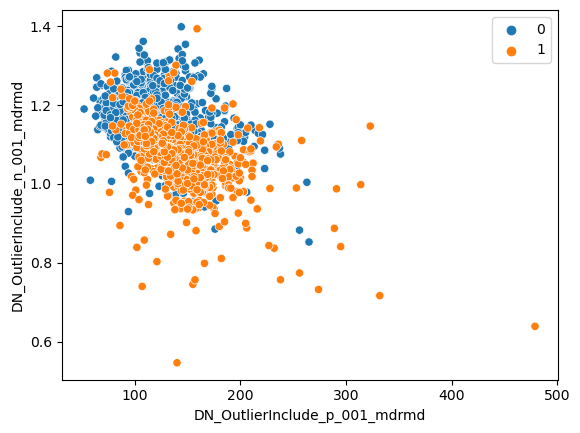

In [63]:
sns.scatterplot(data = df_catch, x='DN_OutlierInclude_p_001_mdrmd',y='DN_OutlierInclude_n_001_mdrmd',hue = train_labels)